# **Requirements and Imports**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle

import os
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

import time
import datetime as dt 

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

import glob
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /gdrive
Num GPUs Available:  1


In [4]:
from tensorflow.keras import datasets, layers, models, losses
from tqdm.keras import TqdmCallback

random_seed = 100
np.random.seed(random_seed)
random.seed(random_seed)

# **Model Definition and Setup**

In [5]:
data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      layers.experimental.preprocessing.RandomRotation(0.2),
    ])

def create_model(data_augmentation=None, l2_reg_factor= 0.001, dropout=0.3):
  #with tf.device("/gpu:0"):
  l2_regularizer = tf.keras.regularizers.l2(l2_reg_factor)

  image_1_input = tf.keras.Input(shape=(image_size[0], image_size[1], 3), name='image_1_input')

  # Rescale
  X = tf.keras.applications.mobilenet.preprocess_input(image_1_input)

  # If we want built in data augmentation
  if data_augmentation != None:
    X = data_augmentation(X)

  # One convolutional layer
  X = layers.Conv2D(3, kernel_size=(5, 5), padding='same', kernel_regularizer = l2_regularizer)(X)
  
  #activation
  X = layers.ReLU()(X)
  #dropout
  X = layers.Dropout(dropout)(X)

  # Max pooling layer
  X = layers.MaxPooling2D()(X)
  
  pretrained_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

  pretrained_model.trainable=False #

  X = pretrained_model(X, training=False)

  # Flattening
  X = tf.keras.layers.GlobalAveragePooling2D()(X)

  # First dense
  X = layers.Dense(512, kernel_regularizer = l2_regularizer)(X)
  X = layers.ReLU()(X)
  X = layers.Dropout(dropout)(X)

  # Output
  outputs = layers.Dense(1)(X)

  model = tf.keras.Model(inputs=[image_1_input], outputs=outputs)
  return model

def get_compiled_model(data_augmentation= None, l2_reg_factor= 0.001, dropout=0.3):
      loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
      model = create_model(data_augmentation, l2_reg_factor, dropout)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
      model.compile(optimizer = optimizer,
                    loss=loss_object,
                    metrics = [tf.keras.metrics.BinaryAccuracy(threshold=.0)])
      return model
      
def make_or_restore_model(infolder, data_augmentation= None, l2_reg_factor= 0.001, dropout=0.3):
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [os.path.join(infolder, name) for name in os.listdir(infolder)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getmtime)
        print("Restoring from", latest_checkpoint)
        return tf.keras.models.load_model(latest_checkpoint)    
    else:
      print("Creating a new model")
      return get_compiled_model(data_augmentation, l2_reg_factor, dropout)

# Classification data testing

In [9]:
save_folder = '/gdrive/Shareddrives/land-app-public/model_weights/single_cnn/'
model = make_or_restore_model(save_folder, l2_reg_factor=0, dropout=0.5)

Restoring from /gdrive/Shareddrives/land-app-public/model_weights/single_cnn/best_model


In [6]:
labels = os.listdir('/gdrive/Shareddrives/land-app-public/training_data/labels')
labels = [l.split('.')[0] for l in labels]

In [8]:
image_path = '/gdrive/Shareddrives/land-app-public/test_data/classification_test/images'
images = os.listdir(image_path)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

image_size = (512, 512)
img_height = image_size[1]
img_width = image_size[0]
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def load_img(file_path):
  #label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

precs = []
recs = []
scores_list = []
actual_list = []

for img in tqdm(images):
  if img.split('.')[0] in labels:
    y =[1]
  else:
    y= [0]

  x = load_img(os.path.join(image_path, img))
  
  output = model(x[np.newaxis, ...], training=False)

  output= tf.math.sigmoid(output)
  actual_list += y
  scores_list += list(output.numpy())

p,r,_ = precision_recall_curve(actual_list, scores_list)
precs.append(p)
recs.append(r)

  0%|          | 0/441 [00:00<?, ?it/s]

In [ ]:
results_path = './'
if not os.path.exists(results_path):
  os.mkdir(results_path)
np.save(results_path+'precisions.npy', precs[0])
np.save(results_path+'recalls.npy', recs[0])


In [ ]:
np.save(results_path+'scores.npy', np.asarray(scores_list))
np.save(results_path+'labels.npy', np.asarray(actual_list))


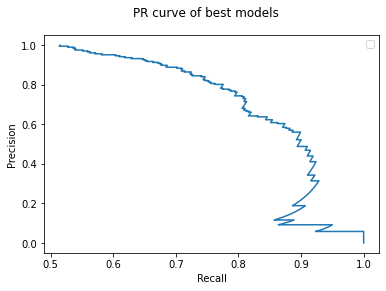

In [ ]:
#PR curves at epoch 75
fig, ax = plt.subplots(1,1)

name = 'single_image_model4_0.5drop_filtering'
#auc = auc(p, r)
ax.plot(p, r,)# label='{}, auc {:.3f}'.format(name, auc))


ax.legend()
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
fig.suptitle("PR curve of best models")
fig.show()